# Atlantic Hurricanes
Initially created to answer the Manifold question [What will be the number of named storms during the 2024 Atlantic hurricane season?](https://manifold.markets/ScottSupak/what-will-be-the-number-of-named-st)

In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import sys
from dataclasses import dataclass
from scipy.optimize import minimize
from typing import Literal, Union

# Data

In [9]:
@dataclass
class StormYear:
    """Data for storms in a single year

    Attributes:
        year: The year of the storm
        num_storms: The number of named storms in that year from the number of entries recorded on https://www.aoml.noaa.gov/hrd/hurdat/<year>.html
    """

    year: int
    num_storms: int

In [10]:
real_data = [
    StormYear(2023, 22),
    StormYear(2022, 17),
    StormYear(2021, 21),
    StormYear(2020, 31),
    StormYear(2019, 19),
    StormYear(2018, 16),
    StormYear(2017, 19),
    StormYear(2016, 16),
    StormYear(2015, 12),
    StormYear(2014, 9),
    StormYear(2013, 15),
    StormYear(2012, 19),
    StormYear(2011, 19),
    StormYear(2010, 19),
    StormYear(2009, 9),
    StormYear(2008, 16),
    StormYear(2007, 15),
    StormYear(2006, 10),
    StormYear(2005, 28),
    StormYear(2004, 15),
    StormYear(2003, 16),
    StormYear(2002, 12),
    StormYear(2001, 15),
    StormYear(2000, 15),
    StormYear(1999, 12),
    StormYear(1998, 14),
    StormYear(1997, 8),
    StormYear(1996, 13),
    StormYear(1995, 19),
    StormYear(1994, 7),
]

## Linear model

This is a bog-standard linear regression except that my prior says that the variance also grows with the year.

### Generate data from the model

In [11]:
def linear_generate_one_year(
    years_since_1994: int,
    slope: float,
    intercept: float,
    std_dev_slope: float,
    std_dev_intercept: float,
) -> int:
    """
    Return a sample of the number of storms in a year from a linear model

    Params:
        years_since_1994: The number of years since 1994
        slope: The slope of the linear model (in storms per year)
        intercept: The intercept of the linear model (in storms)
        std_dev_slope: The standard deviation of the slope (in storms per year)
        std_dev_intercept: The standard deviation of the intercept (in storms)

    """
    return round(
        abs(
            np.random.normal(
                slope * years_since_1994 + intercept,
                abs(std_dev_slope * years_since_1994 + std_dev_intercept),
            )
        )
    )


def linear_storms(
    slope: float, intercept: float, std_dev_slope: float, std_dev_intercept: float
) -> list[StormYear]:
    """Generate a list of StormYear objects from a linear model of both the number of storms and the variance of the number of storms"""
    assert intercept >= 0, "The mean number of storms in 1994 must be non-negative"
    assert (
        slope * (2023 - 1994) + intercept >= 0
    ), "The number of storms in 2023 must be non-negative"
    assert (
        std_dev_intercept >= 0
    ), "The standard deviation of the number of storms in 1994 must be non-negative"
    assert (
        std_dev_slope * (2023 - 1994) + std_dev_intercept >= 0
    ), "The standard deviation of the number of storms in 2023 must be non-negative"
    return [
        StormYear(
            year,
            linear_generate_one_year(
                year - 1994, slope, intercept, std_dev_slope, std_dev_intercept
            ),
        )
        for year in range(1994, 2024)
    ]

In [12]:
np.random.seed(108)
# Source of priors
# 1994-1999 had 12.167 storms per year, 2018-2023 had 21 storms per year
# 1994-1999 had 4.3551 std dev, 2018-2023 had 5.4037 std dev
data_from_prior = linear_storms(9.0 / 24, 12, 1.0 / 24, 4.4)

In [13]:
data_from_prior

[StormYear(year=1994, num_storms=7),
 StormYear(year=1995, num_storms=13),
 StormYear(year=1996, num_storms=18),
 StormYear(year=1997, num_storms=18),
 StormYear(year=1998, num_storms=11),
 StormYear(year=1999, num_storms=14),
 StormYear(year=2000, num_storms=12),
 StormYear(year=2001, num_storms=6),
 StormYear(year=2002, num_storms=15),
 StormYear(year=2003, num_storms=20),
 StormYear(year=2004, num_storms=22),
 StormYear(year=2005, num_storms=20),
 StormYear(year=2006, num_storms=14),
 StormYear(year=2007, num_storms=15),
 StormYear(year=2008, num_storms=13),
 StormYear(year=2009, num_storms=20),
 StormYear(year=2010, num_storms=12),
 StormYear(year=2011, num_storms=21),
 StormYear(year=2012, num_storms=26),
 StormYear(year=2013, num_storms=25),
 StormYear(year=2014, num_storms=21),
 StormYear(year=2015, num_storms=29),
 StormYear(year=2016, num_storms=22),
 StormYear(year=2017, num_storms=20),
 StormYear(year=2018, num_storms=23),
 StormYear(year=2019, num_storms=20),
 StormYear(yea

### Generate the model

In [14]:
def linear_model(data: list[StormYear]) -> pm.Model:
    """Generate the linear model"""
    with pm.Model() as model:
        # In a half-normal distribution, mean = sigma * sqrt(2/pi)
        # so, sigma = mean / sqrt(2/pi) = mean * sqrt(pi/2)
        half_normal_mean_to_sigma = np.sqrt(np.pi / 2)
        slope_z = pm.HalfNormal("slope_z", sigma=1)
        slope_sigma = (9.0 / 24) * half_normal_mean_to_sigma
        slope = pm.Deterministic("slope", slope_z * slope_sigma)
        intercept_z = pm.HalfNormal("intercept_z", sigma=1)
        intercept_sigma = 12 * half_normal_mean_to_sigma
        intercept = pm.Deterministic("intercept", intercept_z * intercept_sigma)
        std_dev_slope_z = pm.HalfNormal("std_dev_slope_z", sigma=1)
        std_dev_slope_sigma = (1.0 / 24) * half_normal_mean_to_sigma
        std_dev_slope = pm.Deterministic(
            "std_dev_slope", std_dev_slope_z * std_dev_slope_sigma
        )
        std_dev_intercept_z = pm.HalfNormal("std_dev_intercept_z", sigma=1)
        std_dev_intercept_sigma = 4.4 * half_normal_mean_to_sigma
        std_dev_intercept = pm.Deterministic(
            "std_dev_intercept", std_dev_intercept_z * std_dev_intercept_sigma
        )
        years_since_1994 = np.array([year.year for year in data]) - 1994
        mu = slope * years_since_1994 + intercept
        sigma = std_dev_slope * years_since_1994 + std_dev_intercept
        pm.NegativeBinomial(
            "observed_storms",
            mu=mu,
            alpha=1 / sigma**2,
            observed=[year.num_storms for year in data],
        )
    return model

### Fit the model with the prior data

In [ ]:
with linear_model(data_from_prior) as prior_model:
    prior_trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_z, intercept_z, std_dev_slope_z, std_dev_intercept_z]


Output()

array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'std_dev_slope'}>,
        <Axes: title={'center': 'std_dev_slope'}>],
       [<Axes: title={'center': 'std_dev_intercept'}>,
        <Axes: title={'center': 'std_dev_intercept'}>]], dtype=object)

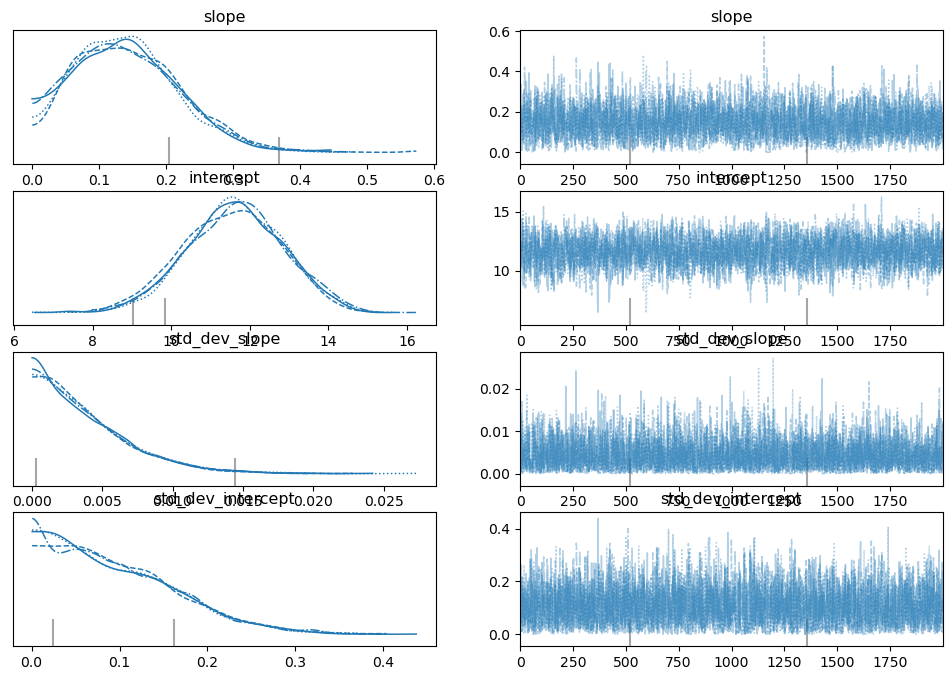

In [66]:
az.plot_trace(
    prior_trace, var_names=["slope", "intercept", "std_dev_slope", "std_dev_intercept"]
)

In [67]:
az.summary(
    prior_trace, var_names=["slope", "intercept", "std_dev_slope", "std_dev_intercept"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.142,0.077,0.000,0.272,0.002,0.001,2142.0,1685.0,1.0
intercept,11.606,1.235,9.329,13.962,0.024,0.017,2560.0,2812.0,1.0
std_dev_slope,0.004,0.003,0.000,0.010,0.000,0.000,3241.0,2191.0,1.0
std_dev_intercept,0.097,0.071,0.000,0.221,0.001,0.001,2550.0,2038.0,1.0


## Sample from the posterior for 2024 and match it to the Manifold question

In [17]:
def sample_2024_storms(trace: pm.backends.base.MultiTrace) -> np.ndarray:
    """
    Sample from the posterior predictive distribution for 2024 storms.

    This uses the NumPy random number generator.

    Note that this uses one sample per storm count. However, it would be
    better to combine this with the bucket count and add a fraction of a
    count to the bucket count according to the known negative binomial
    distribution. Then this would be a deterministic function.

    Parameters:
        trace: The trace object from the MCMC sampling

    Returns:
        An array containing a sample of the predicted storm counts for 2024
    """
    years_since_1994: int = 2024 - 1994

    # Extract posterior samples
    slope_samples: np.ndarray = trace.posterior["slope"].values.flatten()
    intercept_samples: np.ndarray = trace.posterior["intercept"].values.flatten()
    std_dev_slope_samples: np.ndarray = trace.posterior[
        "std_dev_slope"
    ].values.flatten()
    std_dev_intercept_samples: np.ndarray = trace.posterior[
        "std_dev_intercept"
    ].values.flatten()

    # Calculate mu and sigma for 2024
    mu_2024_samples: np.ndarray = slope_samples * years_since_1994 + intercept_samples
    sigma_2024_samples: np.ndarray = (
        std_dev_slope_samples * years_since_1994 + std_dev_intercept_samples
    )

    # Sample from the posterior predictive distribution
    alpha_2024_samples: np.ndarray = 1 / sigma_2024_samples**2
    storms_2024 = [
        np.random.negative_binomial(n=alpha, p=alpha / (alpha + mu))
        for alpha, mu in zip(alpha_2024_samples, mu_2024_samples)
    ]

    return np.array(storms_2024)


def calculate_bucket_probabilities(
    storms_2024: np.ndarray, storms_already: int = 0
) -> dict[str, float]:
    """
    Calculate probabilities for buckets of storm counts from
    https://manifold.markets/ScottSupak/what-will-be-the-number-of-named-st?r=RXJpY01veWVy

    Note that storms_already does not take into account how far along the
    hurricane season is with this many storms.

    Parameters:
        storms_2024: Array of sampled storm counts for 2024
        storms_already: number of storms that have already occurred in 2024

    Returns:
        Dictionary of probabilities for each bucket
    """
    storms_not_ruled_out = storms_2024[storms_2024 >= storms_already]
    s2024 = storms_not_ruled_out
    total_samples: int = len(s2024)
    buckets: dict[str, float] = {
        "0 <= N <= 10": np.sum((s2024 >= 0) & (s2024 <= 10)) / total_samples,
        "11 <= N <= 15": np.sum((s2024 >= 11) & (s2024 <= 15)) / total_samples,
        "16 <= N <= 20": np.sum((s2024 >= 16) & (s2024 <= 20)) / total_samples,
        "21 <= N <= 25": np.sum((s2024 >= 21) & (s2024 <= 25)) / total_samples,
        "26 <= N <= 30": np.sum((s2024 >= 26) & (s2024 <= 30)) / total_samples,
        "31 <= N <= 35": np.sum((s2024 >= 31) & (s2024 <= 35)) / total_samples,
        "36 <= N": np.sum(s2024 >= 36) / total_samples,
    }
    return buckets


def plot_bucket_probabilities(
    bucket_probabilities: dict[str, float], storms_already: int
) -> None:
    """
    Plot the probabilities for each bucket of storm counts.

    Parameters:
        bucket_probabilities: Dictionary of probabilities for each bucket
        storms_already: Number of storms that have already occurred
    """
    plt.figure(figsize=(12, 6))
    bucket_probs = list(bucket_probabilities.values())
    bucket_labels = list(bucket_probabilities.keys())
    plt.bar(range(len(bucket_probs)), bucket_probs, tick_label=bucket_labels)
    # plt.bar(bucket_probabilities.keys(), bucket_probabilities.values())
    plt.title(
        f"Probability Distribution of Hurricanes in 2024 (Given "
        f"{storms_already} storms already)"
    )
    plt.xlabel("Number of Hurricanes")
    plt.ylabel("Probability")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [16]:
prior_2024_storms = sample_2024_storms(prior_trace)
prior_2024_buckets_no_storms = calculate_bucket_probabilities(prior_2024_storms, 0)
prior_2024_buckets_4_storms = calculate_bucket_probabilities(prior_2024_storms, 4)

NameError: name 'prior_trace' is not defined

In [ ]:
prior_2024_buckets_no_storms

In [ ]:
prior_2024_buckets_4_storms

In [ ]:
plot_bucket_probabilities(prior_2024_buckets_no_storms, 0)

# Now let's run the model with the real data

In [ ]:
with linear_model(real_data) as real_model:
    real_trace = pm.sample(2500, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_z, intercept_z, std_dev_slope_z, std_dev_intercept_z]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'std_dev_slope'}>,
        <Axes: title={'center': 'std_dev_slope'}>],
       [<Axes: title={'center': 'std_dev_intercept'}>,
        <Axes: title={'center': 'std_dev_intercept'}>]], dtype=object)

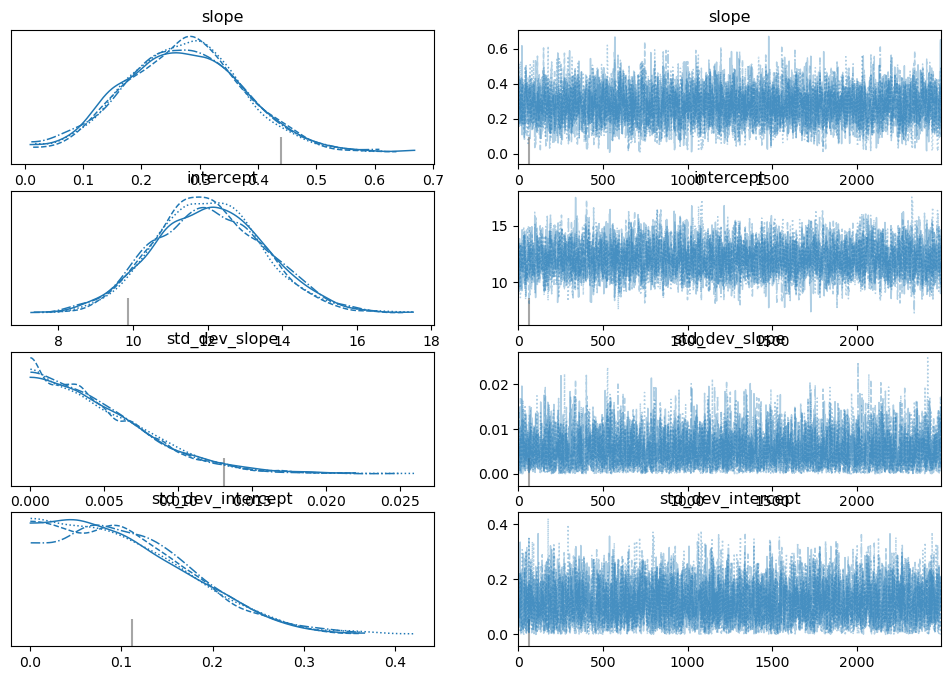

In [19]:
az.plot_trace(
    real_trace, var_names=["slope", "intercept", "std_dev_slope", "std_dev_intercept"]
)

In [20]:
az.summary(
    real_trace, var_names=["slope", "intercept", "std_dev_slope", "std_dev_intercept"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.272,0.101,0.080,0.458,0.002,0.001,3390.0,2820.0,1.0
intercept,12.051,1.461,9.336,14.794,0.025,0.018,3405.0,3997.0,1.0
std_dev_slope,0.005,0.004,0.000,0.011,0.000,0.000,3105.0,2107.0,1.0
std_dev_intercept,0.107,0.072,0.000,0.234,0.001,0.001,3661.0,2697.0,1.0


In [21]:
real_2024_storms = sample_2024_storms(real_trace)
real_2024_buckets_no_storms = calculate_bucket_probabilities(real_2024_storms, 0)
real_2024_buckets_4_storms = calculate_bucket_probabilities(real_2024_storms, 4)

In [22]:
real_2024_buckets_no_storms

{'0 <= N <= 10': 0.0716,
 '11 <= N <= 15': 0.1938,
 '16 <= N <= 20': 0.288,
 '21 <= N <= 25': 0.2344,
 '26 <= N <= 30': 0.1263,
 '31 <= N <= 35': 0.056,
 '36 <= N': 0.0299}

In [23]:
real_2024_buckets_4_storms

{'0 <= N <= 10': 0.06964625713999399,
 '11 <= N <= 15': 0.19420783645655879,
 '16 <= N <= 20': 0.28860607275278083,
 '21 <= N <= 25': 0.23489327587934664,
 '26 <= N <= 30': 0.12656578815512576,
 '31 <= N <= 35': 0.05611784747970738,
 '36 <= N': 0.029962922136486624}

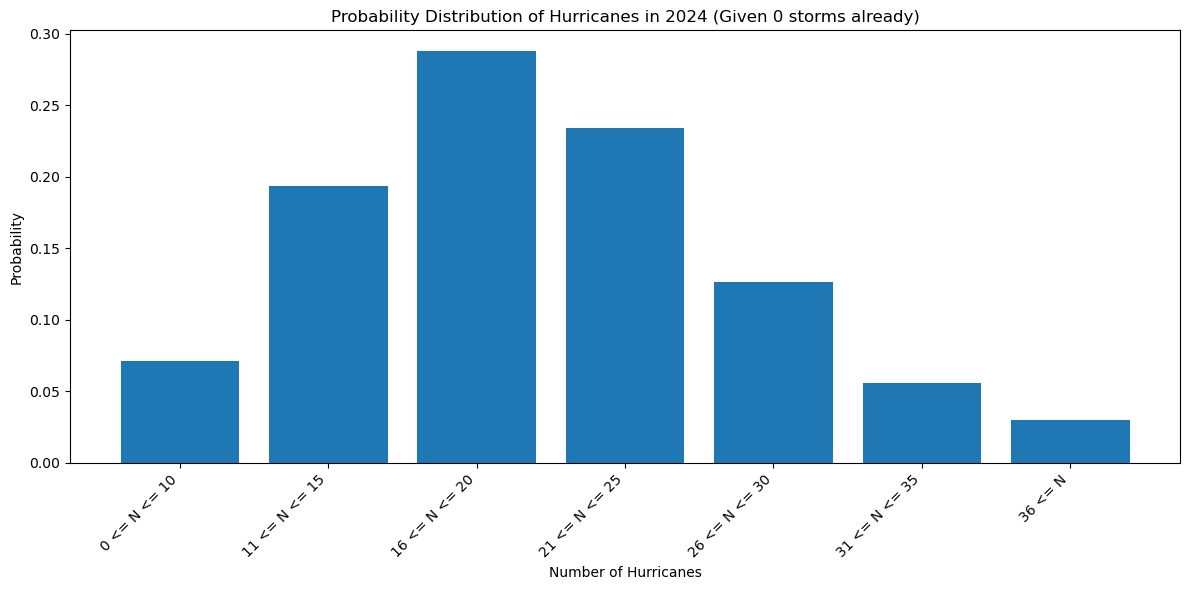

In [24]:
plot_bucket_probabilities(real_2024_buckets_no_storms, 0)

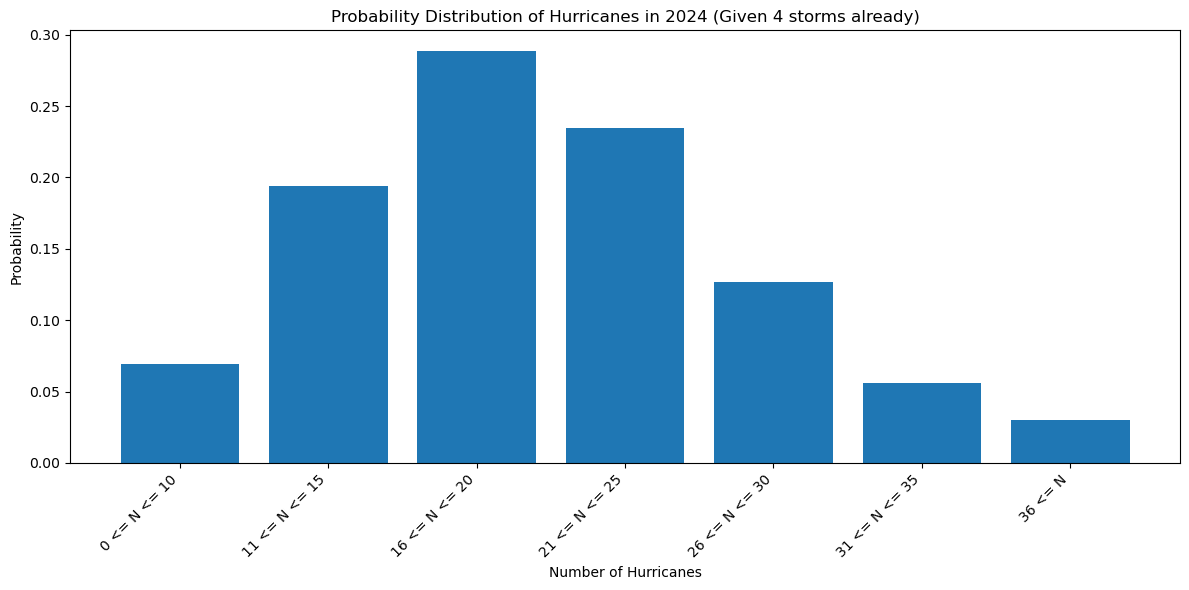

In [25]:
plot_bucket_probabilities(real_2024_buckets_4_storms, 4)

In [26]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Adjust the data because the season is supposed to be more active than usual

There are a number of effects my model does not take into account. In particular, [near-record warm ocean temperatures in the Atlantic and the development of La Niña conditions in the Pacific. NOAA predicts an 85% chance of an above-normal hurricane season.](https://www.npr.org/2024/06/14/nx-s1-5005924/la-nina-atlantic-hurricane-season-us-winter-weather)

Though I could try to adjust the model to account for this and the extra data of how many storms we've had by now, I've already spent a lot of time on this. So, I'll use a fudge-factor and just increase the number of storms in the posterior sample by 10%.

In [27]:
increased_2024_storms = real_2024_storms * 1.05
increased_2024_buckets_no_storms = calculate_bucket_probabilities(
    increased_2024_storms, 0
)

In [28]:
increased_2024_buckets_no_storms

{'0 <= N <= 10': 0.0493,
 '11 <= N <= 15': 0.142,
 '16 <= N <= 20': 0.2314,
 '21 <= N <= 25': 0.2124,
 '26 <= N <= 30': 0.128,
 '31 <= N <= 35': 0.0577,
 '36 <= N': 0.0374}

# Decide how much to bet

I'll maximize ROI

In [29]:
@dataclass(frozen=True)
class Bet:
    """A bet on a binary outcome

    On creation: The amount can be positive or negative. A positive amount is a bet on "yes", a negative amount is a bet on "no".

    Properties:
        outcome: The outcome being bet on
        amount: The amount being bet
    """

    @property
    def outcome(self) -> Literal["yes", "no"]:
        return "yes" if self._amount > 0 else "no"

    @property
    def amount(self) -> float:
        return abs(self._amount)

    _amount: float

    def __str__(self):
        return f"{self.amount} on {self.outcome}"

    def __repr__(self):
        return f"Bet({self._amount})"

    def __add__(self, other: Union[float, "Bet"]) -> "Bet":
        a: float = other._amount if isinstance(other, Bet) else other
        return Bet(self._amount + a)

    def __sub__(self, other: Union[float, "Bet"]) -> "Bet":
        a: float = other._amount if isinstance(other, Bet) else other
        return Bet(self._amount - a)

    def __mul__(self, other: float) -> "Bet":
        return Bet(self._amount * other)

    def __truediv__(self, other: float) -> "Bet":
        return Bet(self._amount / other)


def neg_expected_return(fractions, probs, yes_odds, no_odds):
    """
    Calculate the expected return on investment.

    Parameters:
        fractions: Array of fractions of bankroll to bet (alternating yes/no for each outcome)
        probs: Array of probabilities for each outcome
        yes_odds: Array of odds for "yes" bets
        no_odds: Array of odds for "no" bets

    Returns:
        Negative of the expected return (so minimization will maximize the expected return)
    """
    n_outcomes = len(probs)
    expected_value = 0
    for i in range(n_outcomes):
        # If outcome i occurs
        outcome_value = probs[i] * (
            fractions[2 * i] * yes_odds[i]  # Return from "yes" bet on correct outcome
            + sum(
                fractions[2 * j + 1] * no_odds[j] for j in range(n_outcomes) if j != i
            )  # Return from "no" bets on other outcomes
        )
        expected_value += outcome_value
    return -expected_value  # Return negative for minimization


def max_roi_bets(
    my_probs: dict[str, float], market_probs: dict[str, float], budget: float
) -> dict[str, Bet]:
    """
    Calculate optimal bets to maximize expected return on investment.

    Parameters:
        my_probs: Adjusted model probabilities
        market_probs: Manifold market probabilities
        budget: Total budget for betting

    Returns:
        Dictionary of optimal bets for each outcome
    """
    outcomes = list(my_probs.keys())
    probs = np.array([my_probs[o] for o in outcomes])
    market_p = np.array([market_probs[o] for o in outcomes])

    # Calculate odds for both "yes" and "no" bets
    yes_odds = 1 / market_p - 1
    no_odds = 1 / (1 - market_p) - 1

    # Initial guess: equal fraction for all bets
    initial_fractions = np.ones(2 * len(outcomes)) / (2 * len(outcomes))

    # Constraints: sum of fractions <= 1, all fractions >= 0
    constraints = (
        {"type": "ineq", "fun": lambda x: 1 - np.sum(x)},
        {"type": "ineq", "fun": lambda x: x},
    )

    # Optimize
    result = minimize(
        neg_expected_return,
        initial_fractions,
        args=(probs, yes_odds, no_odds),
        constraints=constraints,
    )

    optimal_fractions = result.x

    # Remove very small fractions
    optimal_fractions[optimal_fractions < 1e-3] = 0

    # Convert fractions to bets
    bets = {}
    for i, outcome in enumerate(outcomes):
        yes_fraction = optimal_fractions[2 * i]
        no_fraction = optimal_fractions[2 * i + 1]
        if yes_fraction > no_fraction:
            bets[outcome] = Bet(yes_fraction * budget)
        else:
            bets[outcome] = Bet(-no_fraction * budget)

    # Re-normalize the bets to use the entire budget
    total_bet = sum(bet.amount for bet in bets.values())
    for outcome in bets:
        bets[outcome] = bets[outcome] * budget / total_bet

    return bets

In [63]:
manifold_probabilities = {
    "0 <= N <= 10": 0.019,
    "11 <= N <= 15": 0.06,
    "16 <= N <= 20": 0.24,
    "21 <= N <= 25": 0.30,
    "26 <= N <= 30": 0.15,
    "31 <= N <= 35": 0.10,
    "36 <= N": 0.12,
}

In [64]:
max_roi_bets(increased_2024_buckets_no_storms, manifold_probabilities, 500)

{'0 <= N <= 10': Bet(500.0),
 '11 <= N <= 15': Bet(-0.0),
 '16 <= N <= 20': Bet(-0.0),
 '21 <= N <= 25': Bet(-0.0),
 '26 <= N <= 30': Bet(-0.0),
 '31 <= N <= 35': Bet(-0.0),
 '36 <= N': Bet(-0.0)}

# I don't know the amount of increase. So, I should sample from the increase and then calculate the bets.

Since the manifold market was under-resourced, so a single bet changed the odds a lot, I repeated this by making a bet, updating the `manifold_probabilities` and then recalculating the bets. I stopped when I'd bet 500 Mana.

In [65]:
sampled_bets: dict[str, Bet] = {
    "0 <= N <= 10": Bet(0.0),
    "11 <= N <= 15": Bet(0.0),
    "16 <= N <= 20": Bet(0.0),
    "21 <= N <= 25": Bet(0.0),
    "26 <= N <= 30": Bet(0.0),
    "31 <= N <= 35": Bet(0.0),
    "36 <= N": Bet(0.0),
}
for _ in range(1000):
    increased_2024_storms = real_2024_storms * (1 + abs(np.random.normal(0, 0.1)))
    increased_2024_buckets_no_storms = calculate_bucket_probabilities(
        increased_2024_storms, 0
    )
    bets = max_roi_bets(increased_2024_buckets_no_storms, manifold_probabilities, 1)
    for outcome in bets:
        sampled_bets[outcome] = sampled_bets[outcome] + bets[outcome]

In [66]:
{o: str(b) for o, b in sampled_bets.items()}

{'0 <= N <= 10': '847.0 on yes',
 '11 <= N <= 15': '152.0 on yes',
 '16 <= N <= 20': '0.0 on no',
 '21 <= N <= 25': '0.0 on no',
 '26 <= N <= 30': '0.0 on no',
 '31 <= N <= 35': '0.0 on no',
 '36 <= N': '1.0 on yes'}

Interesting: only a few of the bets are non-zero. So, most increases only result in the extremes or 16-20. I've already bet on 0-10. So, I should bet on 16-20 and 36+.

In [67]:
500 - 21 - 59 - 250 - 119  # My budget - current bets

51

In [48]:
638 * 170 / (637 + 278)

118.53551912568307

In [49]:
278 * 170 / (637 + 78)

66.0979020979021

# Profit


In [78]:
my_returns = {
    "0 <= N <= 10": 1782,
    "11 <= N <= 15": 2265,
    "16 <= N <= 20": 879,
    "21 <= N <= 25": 568,
    "26 <= N <= 30": 0,
    "31 <= N <= 35": 0,
    "36 <= N": 771,
}
my_costs = 500
sampled_returns = []
for _ in range(10000):
    increased_2024_storms = real_2024_storms * (1 + abs(np.random.normal(0, 0.1)))
    increased_2024_buckets_no_storms = calculate_bucket_probabilities(
        increased_2024_storms, 0
    )
    expected_return = sum(
        my_returns[o] * increased_2024_buckets_no_storms[o] for o in my_returns
    )
    sampled_returns.append(expected_return)
profit = np.array(sampled_returns) - my_costs

array([[<Axes: title={'center': 'Profit from betting on 2024 Atlantic hurricanes (10000 samples)'}, xlabel='Profit', ylabel='Density'>]],
      dtype=object)

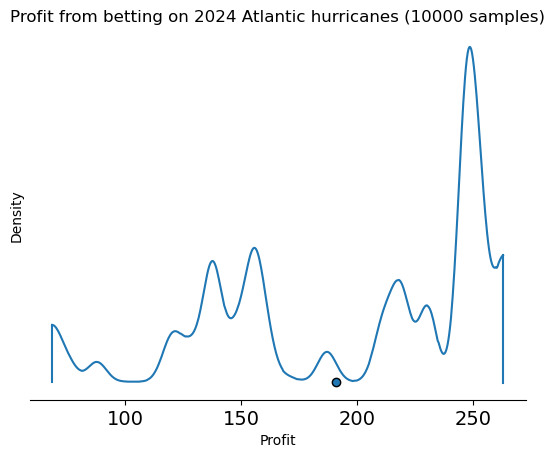

In [104]:
density_plot_ax: list[list[plt.Axes]] = az.plot_density(profit)
density_plot_ax[0][0].set_title(
    "Profit from betting on 2024 Atlantic hurricanes (10000 samples)"
)
density_plot_ax[0][0].set_xlabel("Profit")
density_plot_ax[0][0].set_ylabel("Density")
density_plot_ax

In [105]:
np.percentile(profit, 2.5), np.mean(profit), np.percentile(profit, 97.5)

(50.018100000000004, 190.89576727000005, 262.9828)